# Baseline DenseNet-201

In [ ]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

def check_and_install(package_name):
    try:
        __import__(package_name)
    except ImportError:
        os.system(f'pip install {package_name}')

check_and_install('gdown')

import matplotlib.pyplot as plt
import pathlib
from collections import defaultdict
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from keras.models import load_model
from tensorflow.keras import layers, models, applications
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping

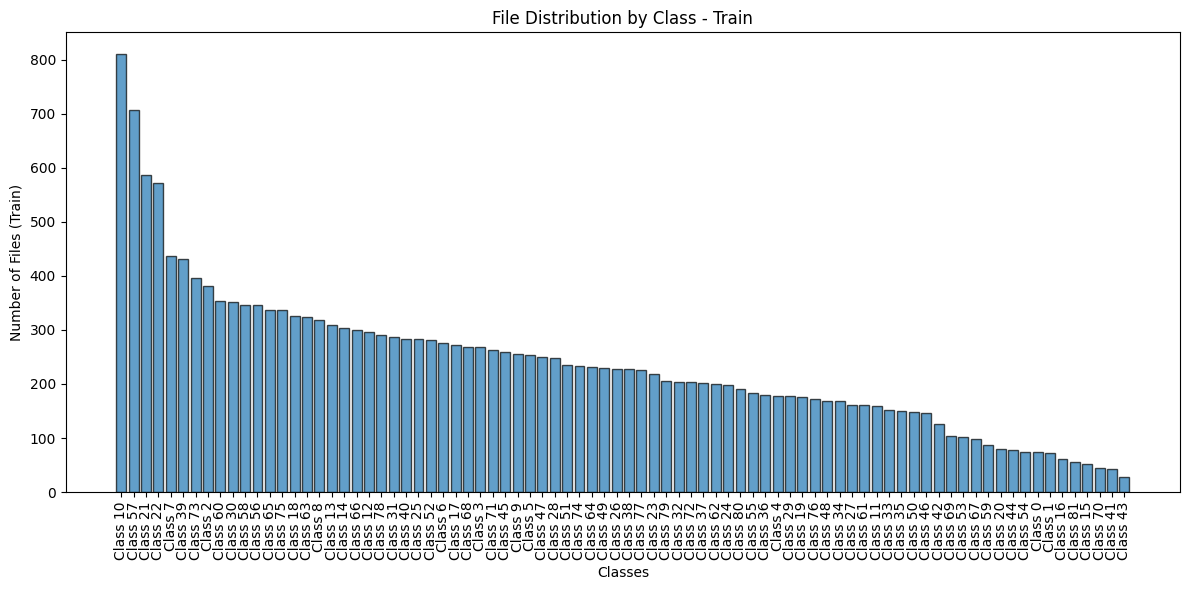

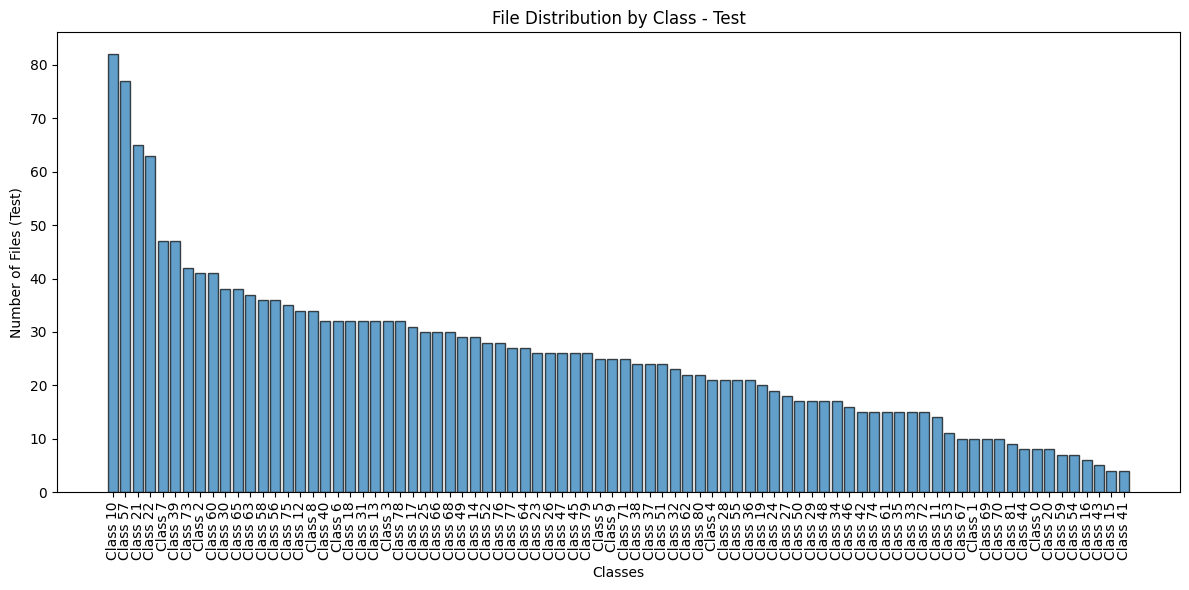

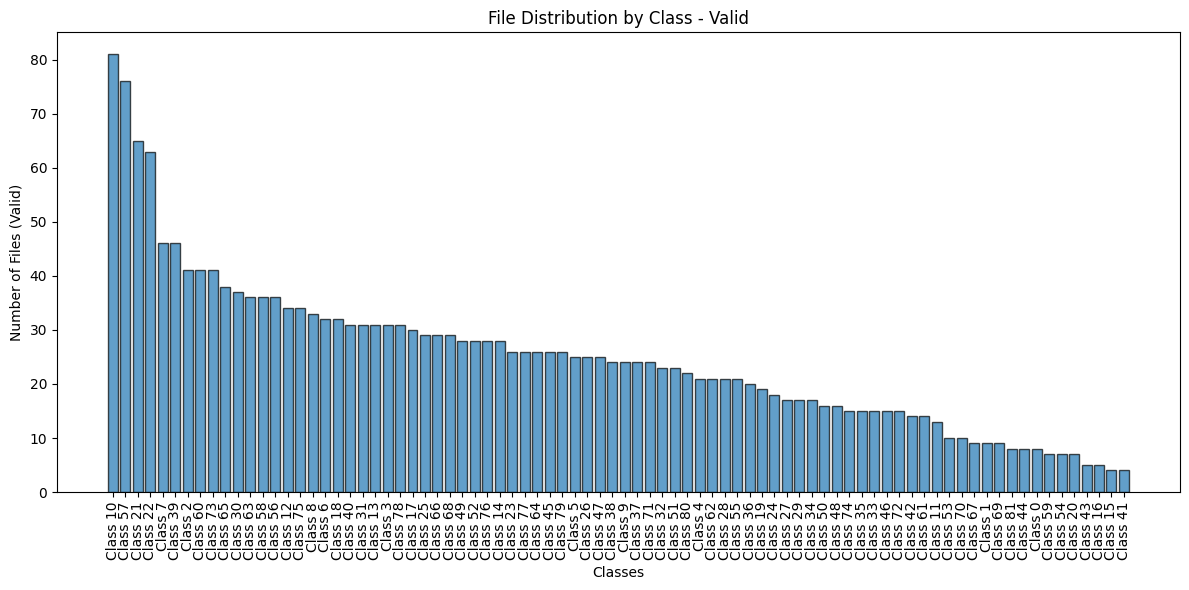


Contagem total por classe com nomes numerados e nomes reais (ordem alfabética):
Class 0 (Akarna_Dhanurasana): Train=74, Test=8, Valid=8, Total=90
Class 1 (Bharadvaja's_Twist_pose_or_Bharadvajasana_I_): Train=72, Test=10, Valid=9, Total=91
Class 2 (Boat_Pose_or_Paripurna_Navasana_): Train=382, Test=41, Valid=41, Total=464
Class 3 (Bound_Angle_Pose_or_Baddha_Konasana_): Train=268, Test=32, Valid=31, Total=331
Class 4 (Bow_Pose_or_Dhanurasana_): Train=178, Test=21, Valid=21, Total=220
Class 5 (Bridge_Pose_or_Setu_Bandha_Sarvangasana_): Train=254, Test=25, Valid=25, Total=304
Class 6 (Camel_Pose_or_Ustrasana_): Train=276, Test=32, Valid=32, Total=340
Class 7 (Cat_Cow_Pose_or_Marjaryasana_): Train=436, Test=47, Valid=46, Total=529
Class 8 (Chair_Pose_or_Utkatasana_): Train=318, Test=34, Valid=33, Total=385
Class 9 (Child_Pose_or_Balasana_): Train=256, Test=25, Valid=24, Total=305
Class 10 (Cobra_Pose_or_Bhujangasana_): Train=810, Test=82, Valid=81, Total=973
Class 11 (Cockerel_Pose): Train

In [ ]:
def count_files_in_all_splits(dataset_path):
    """
    Counts the number of files in each class for the train, test, and valid directories.

    :param dataset_path: Path to the dataset (main directory).
    :return: Dictionary with the class name as the key and the number of files per split as values.
    """
    splits = ['train', 'test', 'valid']  # Main subdirectories
    class_counts = defaultdict(lambda: {'train': 0, 'test': 0, 'valid': 0})

    for split in splits:
        split_path = dataset_path / split
        if not split_path.exists():
            print(f"Subdirectory {split} not found in {dataset_path}")
            continue

        for class_name in os.listdir(split_path):
            class_path = split_path / class_name
            if class_path.is_dir():
                # Count the files in the class folder
                file_count = len([f for f in class_path.iterdir() if f.is_file()])
                class_counts[class_name][split] = file_count

    return class_counts

# Path to the dataset
dataset_path = pathlib.Path('img_ds_clean_aug')  # Modify to the correct path

# Download and unzip the dataset, if necessary
if not dataset_path.exists():
    os.system('gdown 1RE360_MkKZsbhovRQc_9jGnVZbdGCvcv -O dataset_keypoints_yoga.zip') # Drive ID
    os.system('unzip -q dataset_keypoints_yoga.zip')

# Count files in each class
class_file_counts = count_files_in_all_splits(dataset_path)

# Map classes to numbered names
class_name_map = {cls: f"Class {i}" for i, cls in enumerate(class_file_counts)}

# Generate histograms for each split with classes sorted in descending order by file count
for split in ['train', 'test', 'valid']:
    # Sort classes alphabetically to get the mapping
    sorted_class_names = sorted(class_file_counts.keys())  # Alphabetical order
    class_name_map = {cls: f"Class {i}" for i, cls in enumerate(sorted_class_names)}  # Numeric mapping

    # Sort classes by the number of files in the current subset
    sorted_classes_by_count = sorted(class_file_counts.items(), key=lambda x: x[1][split], reverse=True)

    # Map labels to the format "Class X (real_name)"
    classes = [class_name_map[cls] for cls, _ in sorted_classes_by_count]
    file_counts = [counts[split] for _, counts in sorted_classes_by_count]

    # Generate the histogram
    plt.figure(figsize=(12, 6))
    plt.bar(classes, file_counts, edgecolor='black', alpha=0.7)
    plt.xlabel("Classes")
    plt.ylabel(f"Number of Files ({split.capitalize()})")
    plt.title(f"File Distribution by Class - {split.capitalize()}")
    plt.xticks(rotation=90)  # Rotate class names for better readability
    plt.tight_layout()  # Adjust layout to avoid overlap
    plt.show()

sorted_class_names = sorted(class_file_counts.keys())  # Sort real class names alphabetically
class_name_map = {cls: f"Class {i}" for i, cls in enumerate(sorted_class_names)}

# Display total counts with numbered and real names in alphabetical order
print("\nTotal count per class with numbered and real names (alphabetical order):")
for class_name in sorted_class_names:
    mapped_name = class_name_map[class_name]
    counts = class_file_counts[class_name]
    total = sum(counts.values())
    print(f"{mapped_name} ({class_name}): Train={counts['train']}, Test={counts['test']}, Valid={counts['valid']}, Total={total}")

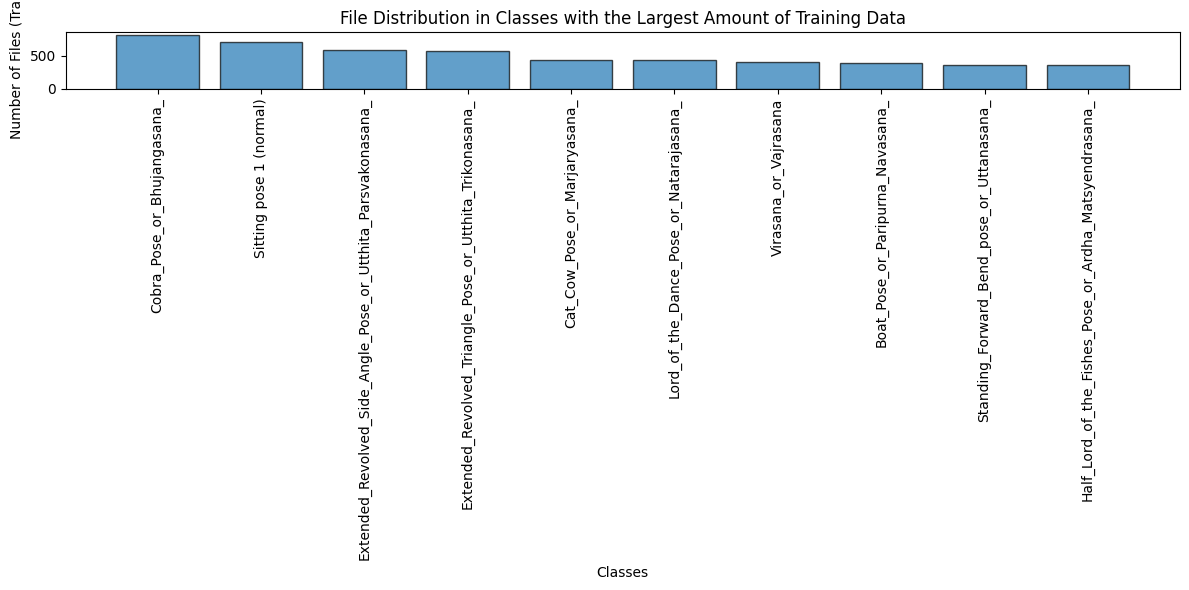


Number of training files in selected classes:
Cobra_Pose_or_Bhujangasana_: 810
Sitting pose 1 (normal): 706
Extended_Revolved_Side_Angle_Pose_or_Utthita_Parsvakonasana_: 586
Extended_Revolved_Triangle_Pose_or_Utthita_Trikonasana_: 572
Cat_Cow_Pose_or_Marjaryasana_: 436
Lord_of_the_Dance_Pose_or_Natarajasana_: 432
Virasana_or_Vajrasana: 396
Boat_Pose_or_Paripurna_Navasana_: 382
Standing_Forward_Bend_pose_or_Uttanasana_: 354
Half_Lord_of_the_Fishes_Pose_or_Ardha_Matsyendrasana_: 352


In [ ]:
train_counts = {cls: counts['train'] for cls, counts in class_file_counts.items()}
sorted_train_classes = sorted(train_counts.items(), key=lambda x: x[1], reverse=True)

# Select the top 10 classes with the largest amount of training data
top_classes = sorted_train_classes[:10]

# Display histograms only for the top 10 classes with the most data in the "train" split
top_class_names = [cls for cls, _ in top_classes]
file_counts = [class_file_counts[cls]['train'] for cls in top_class_names]

plt.figure(figsize=(12, 6))
plt.bar(top_class_names, file_counts, edgecolor='black', alpha=0.7)
plt.xlabel("Classes")
plt.ylabel("Number of Files (Train)")
plt.title("File Distribution in Classes with the Largest Amount of Training Data")
plt.xticks(rotation=90)  # Rotate class names for better readability
plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()

print("\nNumber of training files in selected classes:")
for cls, count in zip(top_class_names, file_counts):
    print(f"{cls}: {count}")

# Data preparation


In [ ]:
batch_size = 32
img_height = 224
img_width = 224
rescale = 1./255

datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=rescale)

print("Training dataset:")
train_ds = datagen.flow_from_directory(
    directory = str(dataset_path/'train'),
    target_size = (img_height, img_width),
    class_mode = 'sparse',
    color_mode = 'rgb',
    seed=123,
    shuffle=True,
    batch_size=batch_size,
    subset = 'training')

print("\nValidation dataset:")
valid_ds = datagen.flow_from_directory(
    directory = str(dataset_path/'valid'),
    target_size = (img_height, img_width),
    class_mode = 'sparse',
    color_mode = 'rgb',
    seed=123,
    shuffle=False,
    batch_size=batch_size)

print("\nTest dataset:")
test_ds = datagen.flow_from_directory(
    directory = str(dataset_path/'test'),
    target_size = (img_height, img_width),
    class_mode = 'sparse',
    color_mode = 'rgb',
    seed=123,
    shuffle=False,
    batch_size=batch_size)

Training dataset:
Found 19508 images belonging to 82 classes.

Validation dataset:
Found 2051 images belonging to 82 classes.

Test dataset:
Found 2096 images belonging to 82 classes.


# MobileNetV2

## Model architecture

In [ ]:
input_shape = (224, 224, 3)

inputs = tf.keras.Input(shape=input_shape)
base_model = applications.MobileNetV2(weights=None, include_top=False, input_shape=input_shape)
base_model.trainable = True
x = base_model(inputs)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(82, activation='softmax', name='output')(x)

model = models.Model(inputs=inputs, outputs=outputs)

In [7]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 82)                  │         105,042 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,363,026 (9.01 MB)

 Trainable params: 2,328,914 (8.88 MB)

 Non-trainable params: 34,112 (133.25 KB)

## Model training

In [ ]:
def scheduler(epoch, lr):
  if epoch < 20:
    return lr
  else:
    return lr * float(tf.math.exp(-0.1))

# Callbacks para treinamento
callbacks = [
    ModelCheckpoint(filepath='densenet201.keras',
                              save_best_only=True,
                              monitor='val_accuracy',
                              verbose=1),
    LearningRateScheduler(scheduler),
    EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)
]

In [9]:
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [10]:
history = model.fit(train_ds,
                    validation_data=valid_ds,
                    epochs=150,
                    callbacks=callbacks)

Epoch 1/150


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 71/610 ━━━━━━━━━━━━━━━━━━━━ 4:09 462ms/step - accuracy: 0.0175 - loss: 4.6263

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


200/610 ━━━━━━━━━━━━━━━━━━━━ 1:55 283ms/step - accuracy: 0.0334 - loss: 4.4784

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


610/610 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.0772 - loss: 4.1222
Epoch 1: val_accuracy improved from -inf to 0.01414, saving model to densenet201.keras
610/610 ━━━━━━━━━━━━━━━━━━━━ 199s 250ms/step - accuracy: 0.0773 - loss: 4.1215 - val_accuracy: 0.0141 - val_loss: 4.5998 - learning_rate: 0.0010
Epoch 2/150
610/610 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.3200 - loss: 2.6511
Epoch 2: val_accuracy improved from 0.01414 to 0.01658, saving model to densenet201.keras
610/610 ━━━━━━━━━━━━━━━━━━━━ 124s 202ms/step - accuracy: 0.3201 - loss: 2.6509 - val_accuracy: 0.0166 - val_loss: 4.8624 - learning_rate: 0.0010
Epoch 3/150
610/610 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.4766 - loss: 1.9614
Epoch 3: val_accuracy did not improve from 0.01658
610/610 ━━━━━━━━━━━━━━━━━━━━ 124s 200ms/step - accuracy: 0.4767 - loss: 1.9613 - val_accuracy: 0.0166 - val_loss: 5.1552 - learning_rate: 0.0010
Epoch 4/150
610/610 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.5906 - loss: 

## Model metrics

Average loss and accuracy during training:
loss: 0.2139 - accuracy: 94.15%
Model validation:
loss: 1.4429 - accuracy: 78.84%


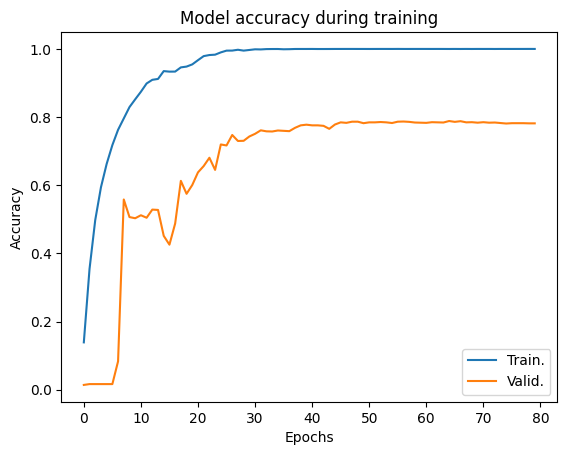

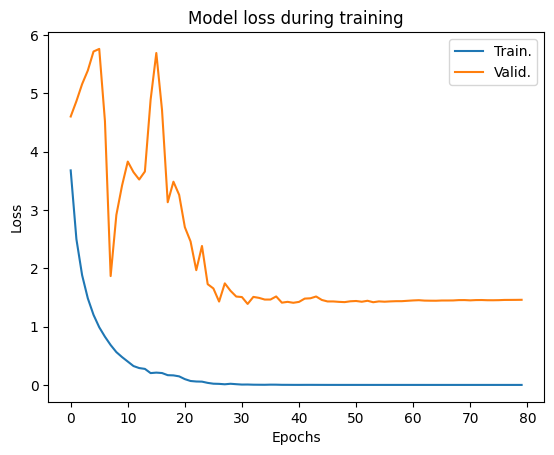

In [12]:
model = load_model("densenet201.keras")

print("Average loss and accuracy during training:")
print(f"loss: {np.average(history.history['loss']):.4f} - accuracy: {np.average(history.history['accuracy']) * 100:.2f}%")

print("Model validation:")
scores = model.evaluate(valid_ds, verbose=0)
print(f'loss: {scores[0]:.4f} - accuracy: {scores[1]* 100:.2f}%')

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy during training')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train.', 'Valid.'], loc='lower right')
plt.show()

print("\n")

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss during training')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train.', 'Valid.'], loc='upper right')
plt.show()

In [21]:
scores = model.evaluate(test_ds, verbose=0)
print("Model testing:")
print(f'loss: {scores[0]:.4f} - accuracy: {scores[1]* 100:.2f}%')

Model testing:
loss: 1.3845 - accuracy: 78.67%


In [22]:
predictions = model.predict(test_ds)

66/66 ━━━━━━━━━━━━━━━━━━━━ 15s 222ms/step


In [23]:
y_pred = np.argmax(predictions, axis=1)

In [ ]:
cm = confusion_matrix(test_ds.classes, y_pred)

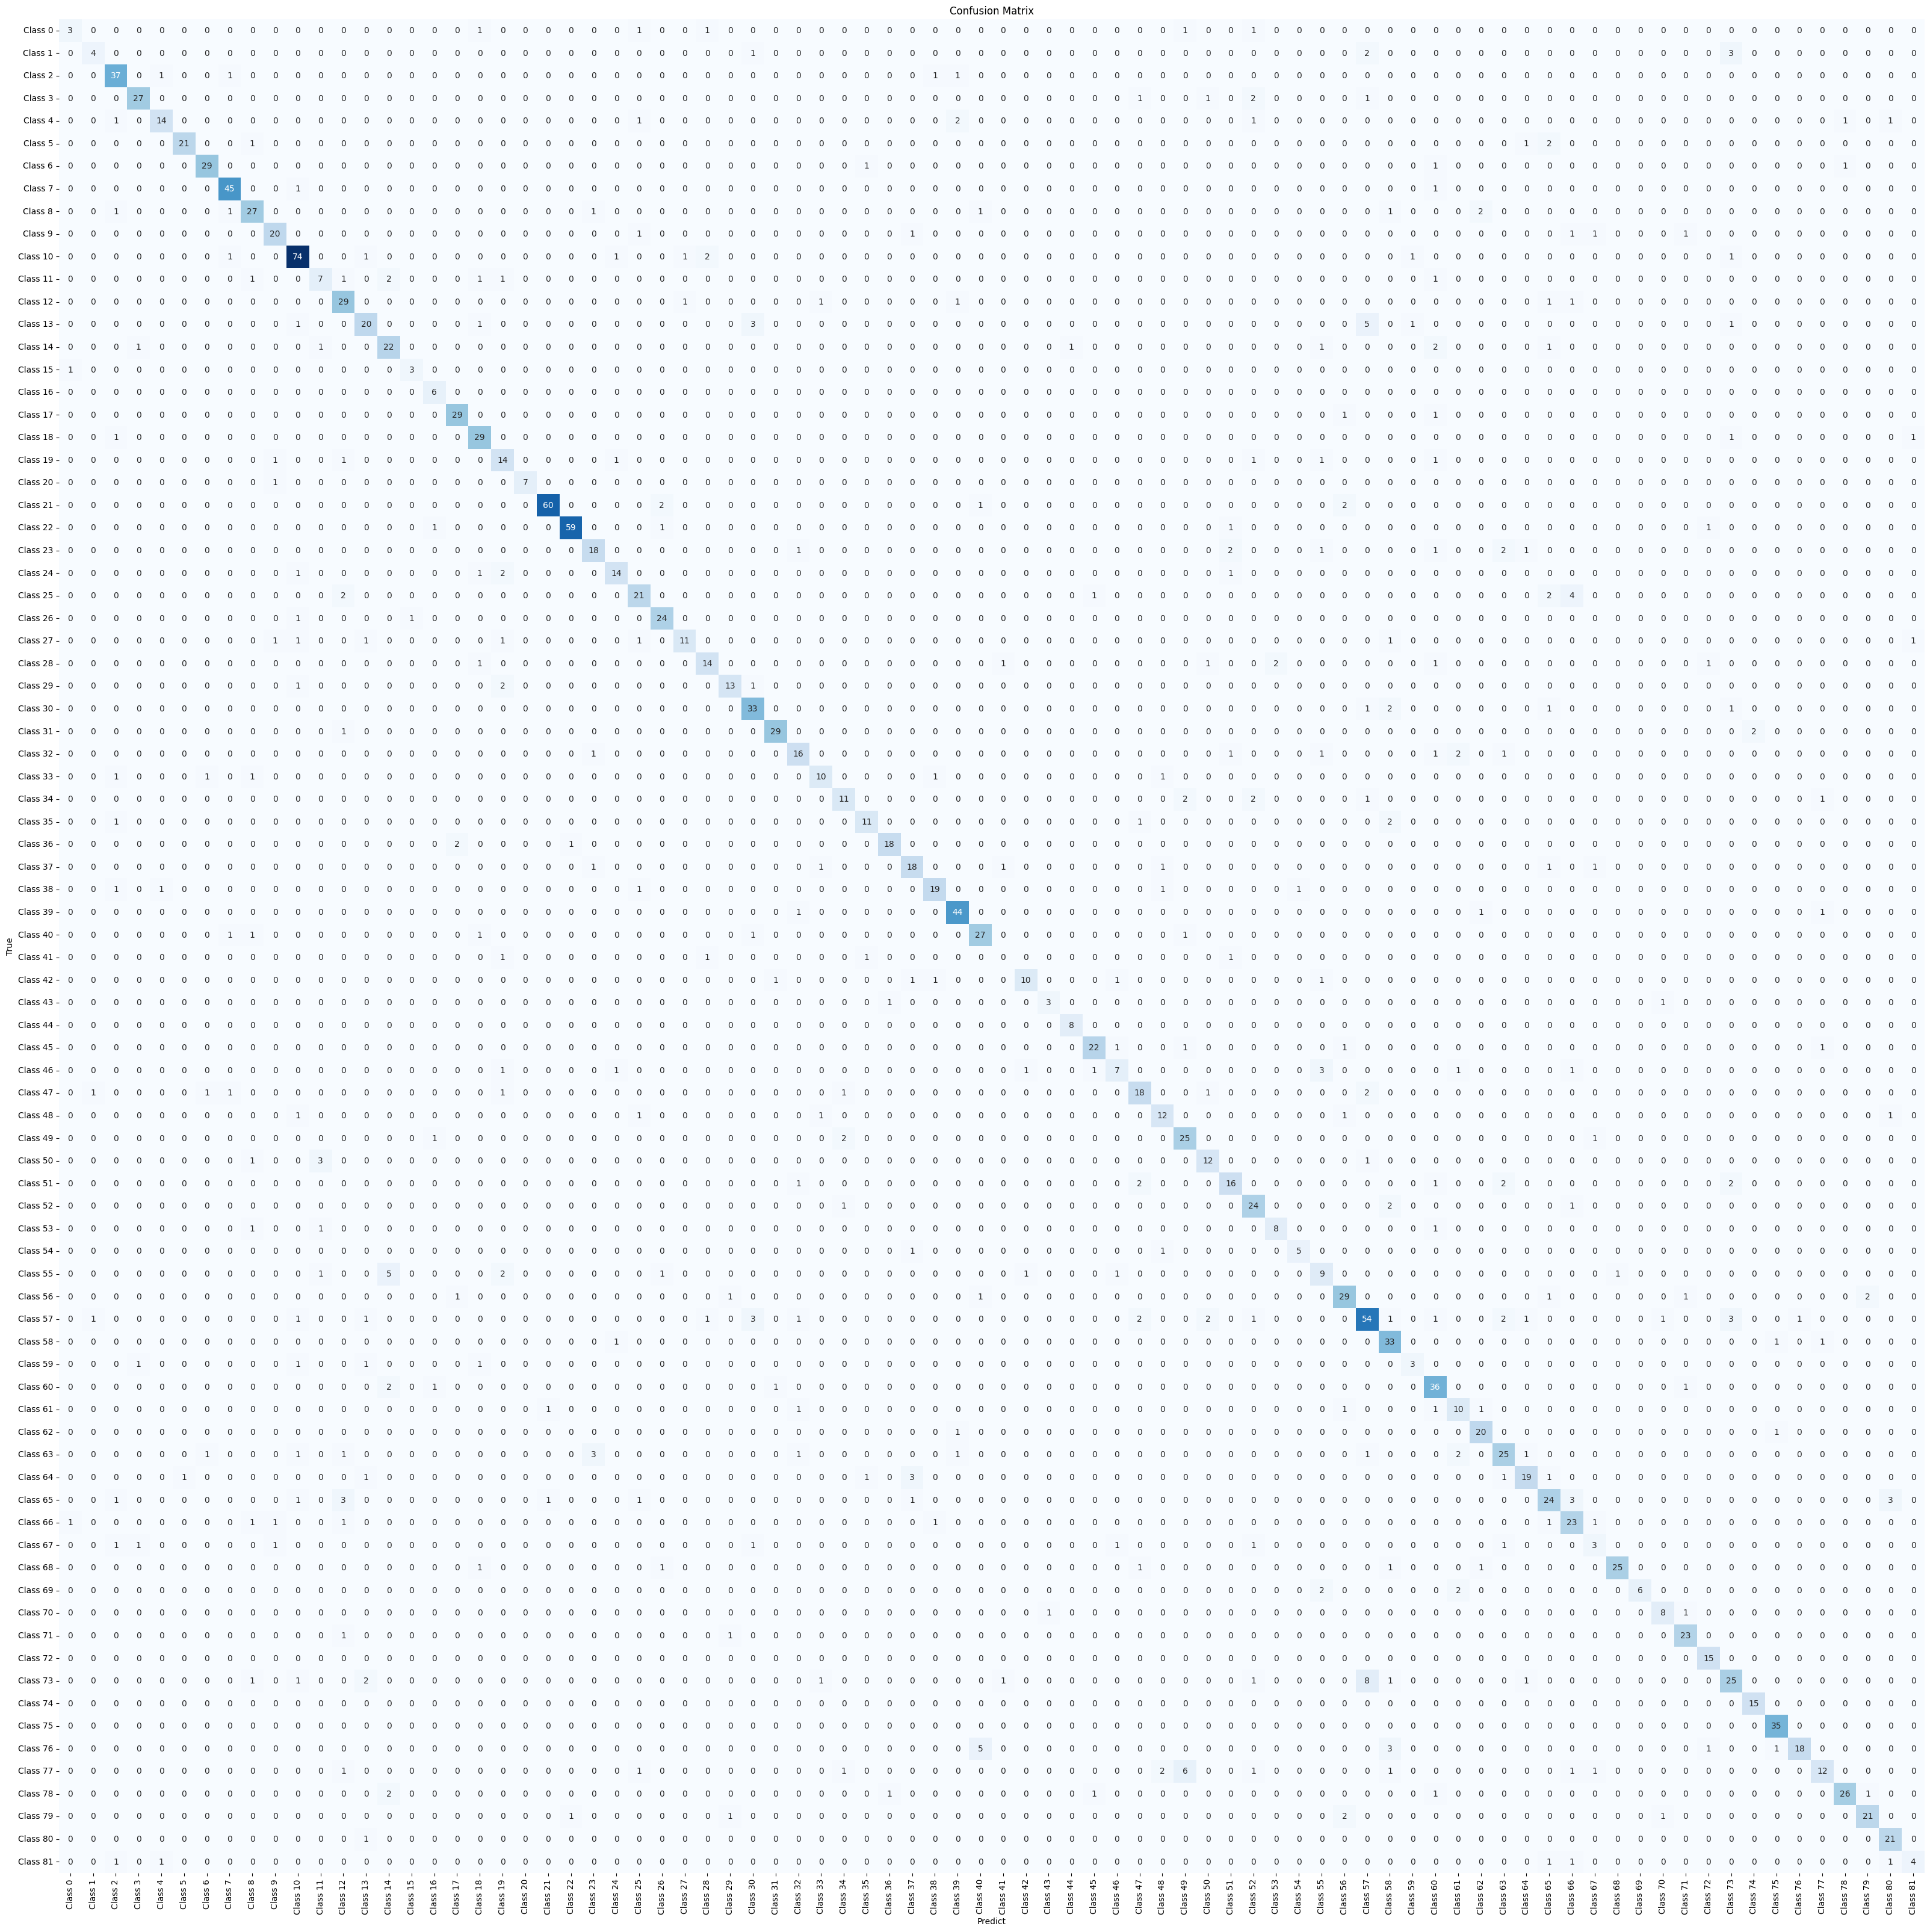

In [ ]:
labels = [class_name_map[cls] for cls in sorted_class_names]

plt.subplots(figsize=(40,40))
sns.heatmap(cm, cmap='Blues',
           annot=True, fmt='d',
           cbar=False,
           xticklabels=labels,
           yticklabels=labels)
plt.title("Confusion Matrix")
plt.ylabel('True')
plt.xlabel('Predict')
plt.show()

In [ ]:
# Classification report
report = classification_report(test_ds.classes, y_pred, target_names=labels, output_dict=True)

pd.DataFrame(report)

,Class 0,Class 1,Class 2,Class 3,Class 4,Class 5,Class 6,Class 7,Class 8,Class 9,...,Class 75,Class 76,Class 77,Class 78,Class 79,Class 80,Class 81,accuracy,macro avg,weighted avg
precision,0.600000,0.666667,0.804348,0.900000,0.823529,0.954545,0.90625,0.900000,0.771429,0.8,...,0.921053,0.947368,0.750000,0.928571,0.875000,0.777778,0.666667,0.786737,0.763211,0.788941
recall,0.375000,0.400000,0.902439,0.843750,0.666667,0.840000,0.90625,0.957447,0.794118,0.8,...,1.000000,0.642857,0.444444,0.812500,0.807692,0.954545,0.444444,0.786737,0.745010,0.786737
f1-score,0.461538,0.500000,0.850575,0.870968,0.736842,0.893617,0.90625,0.927835,0.782609,0.8,...,0.958904,0.765957,0.558140,0.866667,0.840000,0.857143,0.533333,0.786737,0.748230,0.783546
support,8.000000,10.000000,41.000000,32.000000,21.000000,25.000000,32.00000,47.000000,34.000000,25.0,...,35.000000,28.000000,27.000000,32.000000,26.000000,22.000000,9.000000,0.786737,2096.000000,2096.000000
